# **CFDPyRun**

This 'notebook' consists of my run-through of Prof. Lorena Barba's "[12 steps to Navier-Stokes](http://lorenabarba.com/blog/cfd-python-12-steps-to-navier-stokes/)" course, because I admit I have a problem with fluids. It is set in a "professor first, student next" fashion, with the student developing the stock functions with his/her own ideas. The development is presented in order of relevance to the corresponding step rather than chronologically. Most of the partial differential equations here are numerically solved using forward difference methods in time and backward difference methods in space.

Programming CFD methods is crucial in understanding how fluid solvers work because it allows one to learn about all possible points of error when running analyses through industrial software/packages, reducing debugging time in the long run.

#### Python Libraries

In [2]:
import numpy
import sympy
from sympy import init_printing
from sympy.utilities.lambdify import lambdify
import time, sys
from matplotlib import rc, pyplot, cm
from sympy import init_printing
from mpl_toolkits.mplot3d import Axes3D
import timeit
init_printing(use_latex=True)
rc('font',**{'family':'serif'})
rc('text', usetex=True)

### **Step 1: 1D Linear Convection**

#### Professor

Partial differential equation: 

$$ \frac{\partial u}{\partial t} + c\frac{\partial u}{\partial x} = 0 $$

Discretised: 

$$ \frac{u^{n+1}_i - u^n_i}{\Delta t} + c\frac{u^n_i - u^n_{i-1}}{\Delta x} = 0 $$

The initial condition for most of these equations will be a hat function with the following definition:

$$ u(x,0)= \begin{cases} 2, & x \in [0.5,1] \\ 1, & \mathrm{everywhere\;else} \end{cases} $$ 

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


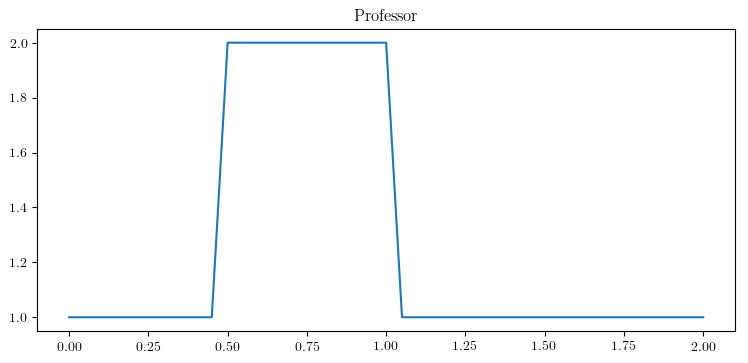

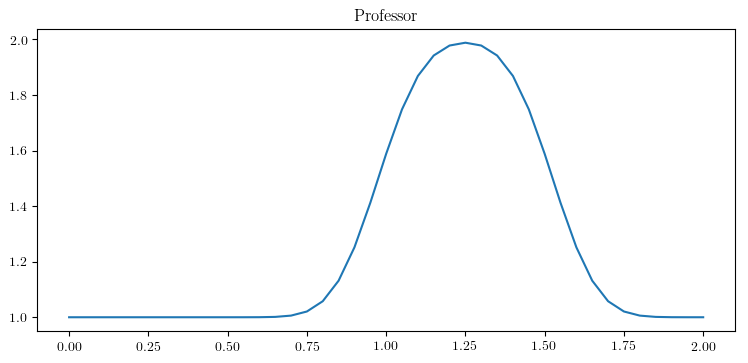

In [2]:
nx = 41
dx = 2.0/(nx-1)
nt = 20
dt = 0.025
c = 1.0

u = numpy.ones(nx)
u[int (.5/dx): int(1/dx + 1)] = 2.0
print(u)

pyplot.figure(1, figsize=(9,4), dpi=100)
pyplot.title('Professor')
pyplot.plot(numpy.linspace(0,2,nx), u)

for n in range(nt):
    un = u.copy()
    for i in range(1,nx):
        u[i] = un[i] - c*dt/dx*(un[i] - un[i-1])

pyplot.figure(2, figsize=(9,4), dpi=100)
pyplot.title('Professor')
pyplot.plot(numpy.linspace(0,2,nx), u)
pyplot.show()

#### Student

No time to lose. (Down with mutability!)

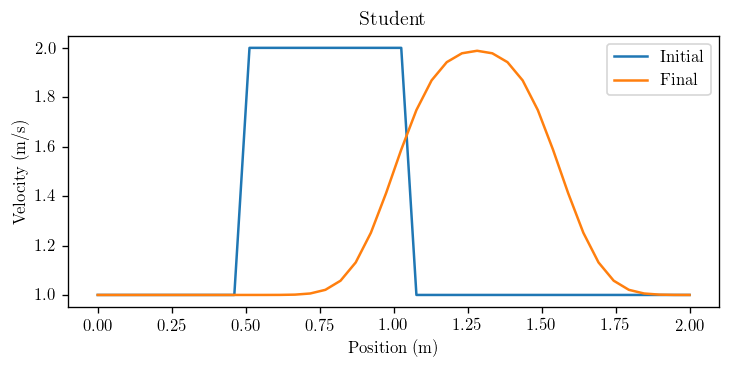

In [3]:
def linearConvection(nx):
    dx = 2.0/nx
    nt = 21
    dt = 0.025
    c = 1
    
    x = numpy.linspace(0,2,nx)
    u = numpy.ones((nt,nx))
    u[0][int (.5/dx): int(1/dx +1)] = 2.0

    for n in range(nt-1):
        for i in range(1,nx):
            u[n+1][i] = u[n][i] - c*dt/dx*(u[n][i] - u[n][i-1])
    
    pyplot.figure(1,figsize=(7,3), dpi=120)
    pyplot.title('Student')
    pyplot.plot(x, u[0], label='Initial')
    pyplot.plot(x, u[nt-1], label='Final')
    pyplot.xlabel('Position (m)')
    pyplot.ylabel('Velocity (m/s)')
    pyplot.legend()

linearConvection(40)

### **Step 2: 1D Nonlinear Convection**

#### Professor

Partial differential equation: 

$$ \frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} = 0 $$

Discretised: 

$$ \frac{u^{n+1}_i - u^n_i}{\Delta t} + u^n_i\frac{u^n_i - u^n_{i-1}}{\Delta x} = 0 $$

Initial condition: 

$$ u(x,0)= \begin{cases} 2, & x \in [0.5,1] \\ 1, & \mathrm{everywhere\;else} \end{cases} $$ 

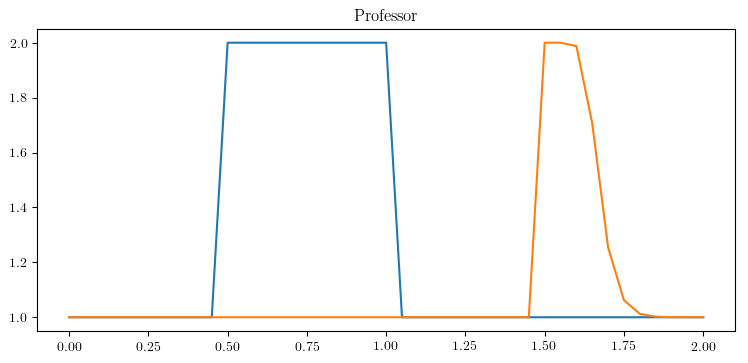

In [4]:
nx = 41
dx = 2.0/(nx-1)
nt = 20
dt = 0.025

u = numpy.ones(nx)
u[int (.5/dx): int(1/dx + 1)] = 2.0

pyplot.figure(figsize=(9,4), dpi=100)
pyplot.title('Professor')
pyplot.plot(numpy.linspace(0,2,nx), u)

for n in range(nt):
    un = u.copy()
    for i in range(1,nx):
        u[i] = un[i]*(1 - dt/dx*(un[i] - un[i-1]))

pyplot.plot(numpy.linspace(0,2,nx), u)
pyplot.show()

#### Student

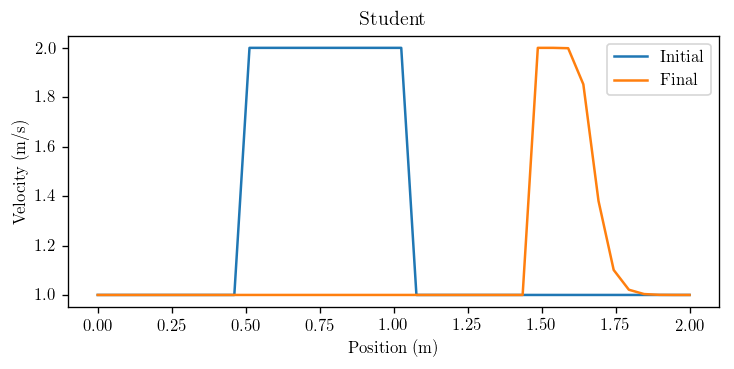

In [5]:
def nonLinearConvection(nx):
    dx = 2.0/nx
    nt = 20
    dt = 0.025
    
    x = numpy.linspace(0,2,nx)
    u = numpy.ones((nt,nx))
    u[0][int (.5/dx): int(1/dx + 1)] = 2.0

    for n in range(nt-1):
        for i in range(1,nx):
            u[n+1][i] = u[n][i]*(1 - dt/dx*(u[n][i] - u[n][i-1]))
            
    return x, u

pos, vel = nonLinearConvection(40)

# Plotting
pyplot.figure(1,figsize=(7,3), dpi=120)
pyplot.title('Student')
pyplot.plot(pos, vel[0], label='Initial')
pyplot.plot(pos, vel[-1], label='Final')
pyplot.xlabel('Position (m)')
pyplot.ylabel('Velocity (m/s)')
pyplot.legend()
pyplot.show()

### **Investigation: CFL Condition**

#### Professor

Courant number: 

$$ \sigma = \frac{u\Delta t}{\Delta x} \leq \sigma_{\max} $$

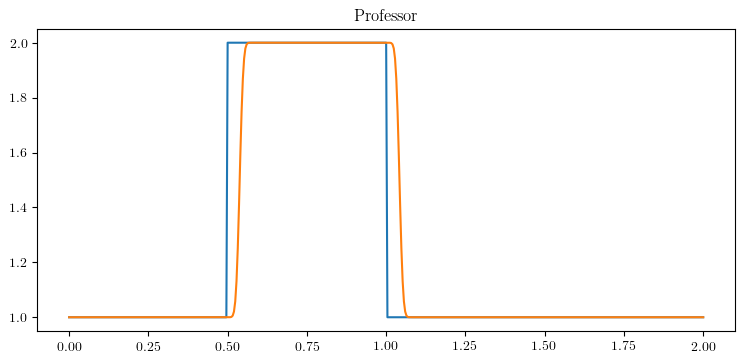

In [6]:
def linearconv(nx):
    dx = 2.0/(nx-1)
    nt = 20
    c = 1.0
    sigma = 0.5
    dt = sigma*dx
    
    u = numpy.ones(nx)
    u[int (.5/dx): int(1/dx + 1)] = 2.0

    pyplot.figure(1, figsize=(9,4), dpi=100)
    pyplot.title('Professor')
    pyplot.plot(numpy.linspace(0,2,nx), u)

    for n in range(nt):
        un = u.copy()
        for i in range(1,nx):
            u[i] = un[i] - c*dt/dx*(un[i] - un[i-1])

    pyplot.plot(numpy.linspace(0,2,nx), u)

linearconv(501)

#### Student

This function allows you to input the simulation time and time-step size and provides warnings if the Courant Number is greater than 1 with recommendations.

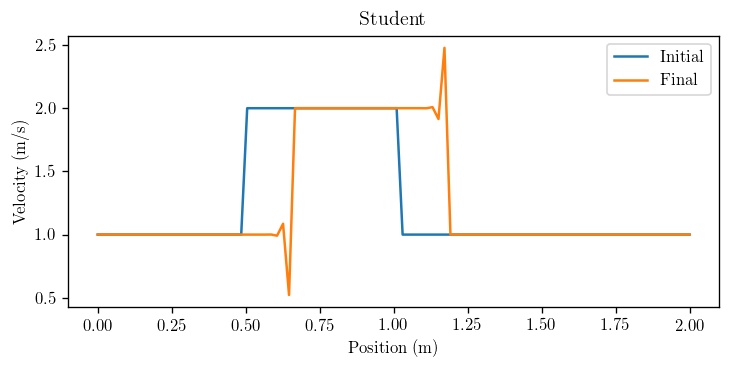

In [7]:
def linearConvectionCFL(mesh_size, time, dt):
    dx = 2.0/mesh_size
    c = 1
    time_steps = int(time/dt)
    sigma_max = dt/dx
    if sigma_max > 1:
        correct_dt = dx
        print('Warning: CFL Number greater than 1. Solver will probably produce incorrect results. Maximum time-step should be %s.' %correct_dt)
    
    # Initial condition definition
    x = numpy.linspace(0,2,mesh_size)
    u = numpy.ones((time_steps,mesh_size))
    u[0][int (.5/dx): int(1/dx + 1)] = 2.0

    for n in range(time_steps-1):
        for i in range(1,mesh_size):
            u[n+1][i] = u[n][i] - c*dt/dx*(u[n][i] - u[n][i-1])
            
    return x, u
    
pos, vel = linearConvectionCFL(100, 0.2, 0.021)

# Plotting
pyplot.figure(1,figsize=(7,3), dpi=120)
pyplot.title('Student')
pyplot.plot(pos, vel[0], label='Initial')
pyplot.plot(pos, vel[-1], label='Final')
pyplot.xlabel('Position (m)')
pyplot.ylabel('Velocity (m/s)')
pyplot.legend()
pyplot.show()

### **Step 3: Diffusion Equation in 1D**

#### Professor

Partial differential equation: 

$$ \frac{\partial u}{\partial t} = \nu \frac{\partial^2 u}{\partial x^2} $$

Discretised:

$$ \frac{u^{n+1}_i - u^n_i}{\Delta t} = \nu\frac{u^n_{i+1} - 2u^n_i + u^n_{i-1}}{(\Delta x)^2} $$

Initial condition: 

$$ u(x,0)= \begin{cases} 2, & x \in [0.5,1] \\ 1, & \mathrm{everywhere\;else} \end{cases} $$ 

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


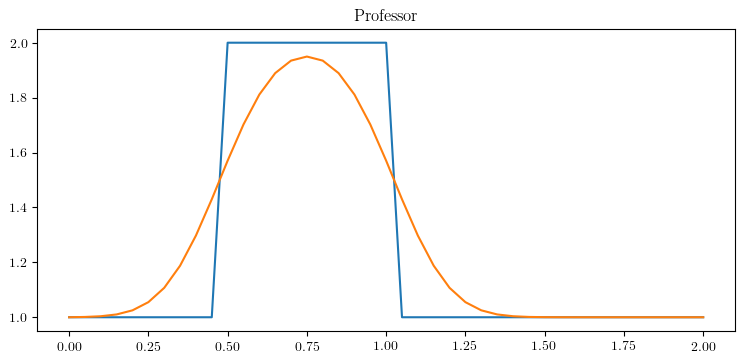

In [8]:
nx = 41
dx = 2.0/(nx-1)
nt = 20
nu = 0.3
sigma = 0.2
dt = sigma*dx**2/nu

u = numpy.ones(nx)
u[int (.5/dx): int(1/dx + 1)] = 2.0
print(u)

pyplot.figure(1, figsize=(9,4), dpi=100)
pyplot.title('Professor')
pyplot.plot(numpy.linspace(0,2,nx), u)

for n in range(nt):
    un = u.copy()
    for i in range(1,nx - 1):
        u[i] = un[i] + nu*dt/dx**2*(un[i+1] - 2*un[i] + un[i-1] )

pyplot.plot(numpy.linspace(0,2,nx), u)
pyplot.show()

#### Student

__Analytical Solution of the Diffusion Equation using a Fourier Transform:__

Take the spatial Fourier transform $\mathcal F_x$ of the equation with an initial value problem:

$$ \frac{\partial u_F(k,t)}{\partial t} + \nu k^2 u_F(k,t) = 0 $$ 

This ODE is easily solved:

$$ u_F(k,t) = u(k,0)e^{-\nu k^2 t}, \quad u(k,0) = \mathcal F_x[u(x,0)] $$

To find the inverse spatial Fourier transform, we invoke the convolution theorem:

$$ u(x,t) = \mathcal F_x^{-1}\left[u_F(k,t)\right] =  \mathcal F_x^{-1}[u(k,0)] * \mathcal F_x^{-1} \left[e^{-\nu k^2 t}\right] = u(x,0) * \mathcal F_x^{-1} \left[e^{-\nu k^2 t}\right] $$

The second inverse transform is the Fourier transform of a Gaussian, which is nicely found in the following manner. Let $f(k) = e^{-\nu k^2 t}$ (with $\nu$ and $t$ as parameters), now differentiate and take the Fourier transform:

$$ ixf(x) = -2\nu t \cdot i f'(x) $$ 

$$ \implies f(x) = \frac{1}{\sqrt{4\pi\nu t}}\exp\left(-\frac{x^2}{4\nu t}\right) $$

Using the definition of convolution, the solution can be expressed as:

$$ u(x,t) = \frac{1}{\sqrt{4\pi\nu t}}\int_{-\infty}^{\infty} u(y,0)\exp\left[-\frac{(x-y)^2}{4\nu t}\right] \mathrm dy $$

__Note:__ This looks strangely similar to a Green's function with the kernel:

$$ G(x,t;y,t) = \frac{1}{\sqrt{4\pi\nu t}}\exp\left[-\frac{(x-y)^2}{4\nu t}\right] $$

Let's apply this to the current case:

$$ u(x,t) =  \frac{1}{\sqrt{4\pi\nu t}}\int_{-\infty}^{0.5}\exp\left[-\frac{(x-y)^2}{4\nu t}\right] \mathrm dy + \frac{2}{\sqrt{4\pi\nu t}}\int_{0.5}^{1}\exp\left[-\frac{(x-y)^2}{4\nu t}\right] \mathrm dy +  \frac{1}{\sqrt{4\pi\nu t}}\int_{1}^{\infty}\exp\left[-\frac{(x-y)^2}{4\nu t}\right] \mathrm dy$$

There's no closed-form solution for these integrals. `:(` But these are expressible using the error function with the substitution:

$$ \frac{x-y}{\sqrt{4\nu t}} = u, \quad \mathrm{erf}(x) =  \frac{2}{\sqrt{\pi}}\int_{0}^{x}e^{-u^2} \mathrm du $$

$$ \implies  u(x,t) =  1 - \frac{1}{2}\mathrm{erf}\left(\frac{x-1}{\sqrt{4\nu t}}\right) + \frac{1}{2}\mathrm{erf}\left(\frac{x-0.5}{\sqrt{4\nu t}}\right)$$

We can now compare our solver's accuracy with this "analytical" solution!

__Note__: This version forces the Courant Number to be 0.2 and calculates the time-step based on the mesh size accordingly for "accurate" results. It takes user input of simulation time and also runs a calculation using the "analytical" solution for comparison.

In [9]:
## Analytical solution setup using SymPy
x, t, nu = sympy.symbols('x t nu')
u_diffusion = 1 - 0.5*sympy.erf((x-1)/(sympy.sqrt(4*nu*t))) + 0.5*sympy.erf((x-0.5)/(sympy.sqrt(4*nu*t)))
u_func_diffusion = sympy.lambdify((t,x,nu), u_diffusion, modules=['numpy', 'sympy'])

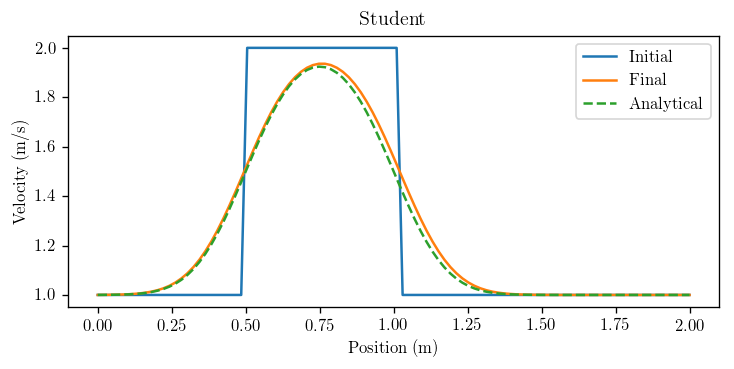

In [10]:
def diffusionEquation(mesh_size, time):
    dx = 2.0/mesh_size
    nu = 0.3
    sigma_max = 0.2
    dt = sigma_max*dx**2/nu
    time_steps = int(time/dt)
    
    ## Initial condition definition
    x = numpy.linspace(0,2,mesh_size)
    u = numpy.ones((time_steps,mesh_size))
    u[0][int (.5/dx): int(1/dx + 1)] = 2.0
    u_analytical = numpy.asarray([u_func_diffusion(time_steps*dt, xi, nu) for xi in x])
    
    for n in range(time_steps-1):
        for i in range(1,mesh_size - 1):
            u[n+1][i] = u[n][i] + nu*dt/dx**2*(u[n][i+1] - 2*u[n][i] + u[n][i-1])
    
    return x, u, u_analytical

pos, vel, vel_analytical = diffusionEquation(100, 0.0333)

# Plotting
pyplot.figure(1,figsize=(7,3), dpi=120)
pyplot.title('Student')
pyplot.plot(pos, vel[0], label='Initial')
pyplot.plot(pos, vel[-1], label='Final')
pyplot.plot(pos, vel_analytical, '--', label='Analytical')
pyplot.xlabel('Position (m)')
pyplot.ylabel('Velocity (m/s)')
pyplot.legend()
pyplot.show()

### **Step 4: Burgers' Equation**

### Professor

Partial differential equation: 

$$ \frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} = \nu\frac{\partial^2 u}{\partial x^2} $$

Discretised: 

$$ \frac{u^{n+1}_i - u^n_i}{\Delta t} + u^n_i\frac{u^n_i - u^n_{i-1}}{\Delta x} = \nu\frac{u^n_{i+1} - 2u^n_i + u^n_{i-1}}{(\Delta x)^2} $$

__Student's modification:__ The notation has been clarified compared to the original presentation (including a missing condition).

Initial conditions (using the analytical solution): 

$$ \phi(x,t)_{t=0} = \exp\left[-\frac{\left(x - 4t - 2\pi\right)^{2}}{4 \nu \left(t + 1\right)}\right] + \exp\left[- \frac{\left(x-4t\right)^{2}}{4 \nu \left(t + 1\right)}\right] $$

$$ u(x,0) = -\frac{2\nu}{\phi}\frac{\partial\phi}{\partial x} + 4 = - \frac{2 \nu}{e^{- \frac{\left(x - 2\pi\right)^{2}}{4 \nu}} + e^{- \frac{x^{2}}{4 \nu}}} \left(- \frac{x e^{- \frac{x^{2}}{4 \nu}}}{2 \nu} - \frac{1}{4 \nu} \left(2 x - 4\pi\right) e^{- \frac{\left(x - 4\pi\right)^{2}}{4 \nu}}\right) + 4 $$

Boundary conditions: 

$$ u(0,t) = u(2\pi,t), \quad u'(0,t) = u'(2\pi, t)$$



In [11]:
## Analytical solution setup using SymPy
x, t, nu = sympy.symbols('x t nu')
phi = sympy.exp(-(x-4*t)**2/(4*nu*(t+1))) + sympy.exp(-(x-4*t-2*numpy.pi)**2/(4*nu*(t+1)))
diffphi = sympy.diff(phi, x)
u = -2*nu/phi*diffphi + 4
ufunc = sympy.lambdify((t,x,nu), u, modules=['sympy'])

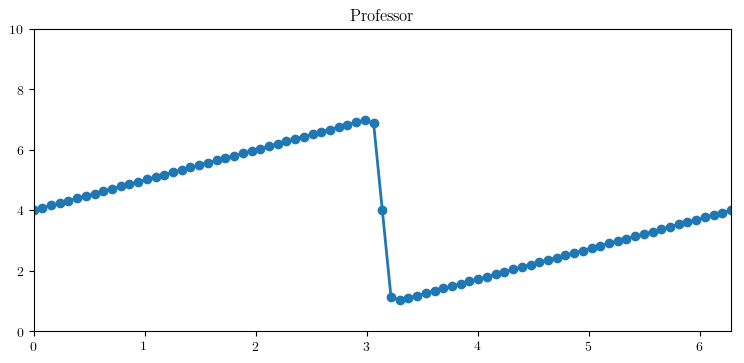

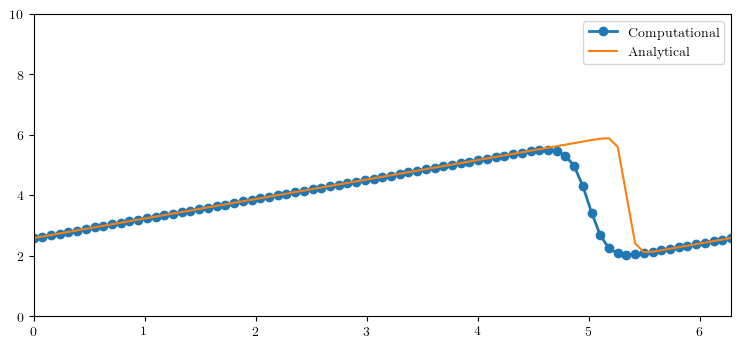

In [12]:
nx = 81
dx = 2.0*numpy.pi/(nx-1)
nt = 100
nu = 0.07
dt = dx*nu

x = numpy.linspace(0, 2*numpy.pi,nx)
un = numpy.empty(nx)
t = 0

u = numpy.asarray([ufunc(t,x0,nu) for x0 in x])

pyplot.figure(figsize=(9, 4),dpi=100)
pyplot.title('Professor')
pyplot.plot(x, u, marker='o', lw=2)
pyplot.xlim([0, 2 * numpy.pi])
pyplot.ylim([0, 10])

for n in range(nt):
    un = u.copy()
    for i in range(1,nx-1):
        u[i] = un[i]*(1-dt/dx*(un[i] - un[i-1])) + nu*dt/dx**2*(un[i+1] - 2*un[i] + un[i-1])
    u[0] = un[0]*(1-dt/dx*(un[0] - un[-2])) + nu*dt/dx**2*(un[1] - 2*un[0] + un[-2])
    u[-1] = u[0]

u_analytical = numpy.asarray([ufunc(nt*dt, xi, nu) for xi in x])

# Plotting
pyplot.figure(figsize=(9, 4),dpi=100)
pyplot.plot(x, u, marker='o', lw=2, label='Computational')
pyplot.plot(x, u_analytical, label='Analytical')
pyplot.xlim([0, 2 * numpy.pi])
pyplot.ylim([0, 10])
pyplot.legend()
pyplot.show()

#### Student

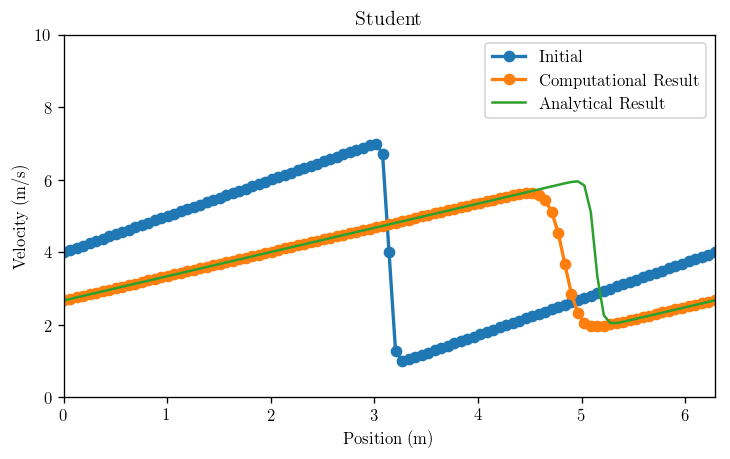

In [13]:
def burgersEquation(mesh_size, time):
    dx = 2.0*numpy.pi/(mesh_size-1)
    nu = 0.07
    dt = dx*nu
    timesteps = int(time/dt)
    
    x = numpy.linspace(0, 2*numpy.pi, mesh_size)
    u = numpy.empty((timesteps,mesh_size))
    u_analytical = numpy.asarray([ufunc(timesteps*dt, xi, nu) for xi in x])
    
    u[0] = numpy.asarray([ufunc(0,x0,nu) for x0 in x])
    
    for n in range(timesteps-1):
        for i in range(1,mesh_size-1):
            u[n+1][i] = u[n][i]*(1-dt/dx*(u[n][i] - u[n][i-1])) + nu*dt/dx**2*(u[n][i+1] - 2*u[n][i] + u[n][i-1]) 
            u[n+1][0] = u[n][0]*(1-dt/dx*(u[n][0] - u[n][-2])) + nu*dt/dx**2*(u[n][1] - 2*u[n][0] + u[n][-2])
            u[n+1][-1] = u[n+1][0]
    
    return x, u, u_analytical

pos, vel, vel_analytical = burgersEquation(101,0.5)

# Plotting
pyplot.figure(1,figsize=(7,4), dpi=120)
pyplot.title('Student')
pyplot.plot(pos, vel[0], marker='o', lw=2, label = 'Initial')
pyplot.plot(pos, vel[-1], marker='o', lw=2, label='Computational Result')
pyplot.plot(pos, vel_analytical, label='Analytical Result')
pyplot.xlabel('Position (m)')
pyplot.ylabel('Velocity (m/s)')
pyplot.xlim([0, 2*numpy.pi])
pyplot.ylim([0, 10])
pyplot.legend()
pyplot.show()

### **Aside: Kardar–Parisi–Zhang equation**

#### Student

The KPZ equation is a generalisation of Burgers' equation to multiple dimensions. Write Burgers' equation in the form:

$$ \frac{\partial u}{\partial t} + \frac{1}{2}\frac{\partial u^2}{\partial x} = \nu\frac{\partial^2 u}{\partial x^2} $$

Let $ u = \psi_x $, then Burgers' equation becomes:

$$ \psi_{tx} + \psi_x\psi_{xx} = \nu\psi_{xxx} $$

$$ \partial_x\left(\psi_t + \frac{\psi_x^2}{2} \right) = \nu\partial_x(\psi_{xx}) $$ 

Integrating with respect to x gives the following equation:

$$ \frac{\partial \psi}{\partial t} + \frac{1}{2}\left(\frac{\partial \psi}{\partial x}\right)^2 = \nu\frac{\partial^2 \psi}{\partial x^2} + \alpha(t) $$

If $\alpha(t) = 0$, we obtain the KPZ equation in one dimension, which seemingly generalises to:

$$ \frac{\partial \psi}{\partial t} + \frac{\lambda}{2}\left(\nabla \psi\right)^2 = \nu\nabla^2 \psi $$

Whatever "$(\nabla \psi)^2$" means. Let $\lambda = 1$ and take the one-dimensional case, then the equation has an integrating factor (thanks to Vyn from freenode's `##math`!), which allows it to be written in the form of the 1-D diffusion equation:

$$ \frac{\partial}{\partial t}\left[\exp\left(-\frac{\psi}{2\nu}\right)\right] = \nu\frac{\partial^2}{\partial x^2}\left[\exp\left(-\frac{\psi}{2\nu}\right)\right] $$

Let's use the 1D diffusion equation solver on this:

__Analytical Solution of the Diffusion Equation using a Laplace Transform:__

Taking the Laplace transform $\mathcal L_t$ in time:

$$ su_L(x,s) - u(x,0) = \nu \frac{\partial^2 u_L}{\partial x^2}, \quad x \in [0,2\pi] $$

$$ \frac{\partial^2 u_L}{\partial x^2} + \alpha^2 u_L = \frac{-u(x,0)}{\nu}, \quad \alpha = i\omega, \quad \omega = \sqrt{\frac{s}{\nu}} $$

Looks like this is how the Green's function pops up (more canonically, of course).

$$ u_L(x,s) = Ae^{i\omega x} + A^*e^{-i\omega x} + u_p(x,s), \quad A = \frac{1}{2}\left(u(0,s) - i\frac{u'(0,s)}{\omega}\right) $$

The particular solution $u_p$ is found by using Green's function for the harmonic oscillator:

$$ G(x,s;k,s) = \frac{\sin \alpha(x-k)}{\alpha} = \frac{\sinh \omega(x-k)}{\omega}$$

$$ \implies u_p(x,s) = \int_{R} G(x,s;k,s) u(k,0)\,\mathrm dk = \frac{1}{\sqrt{s\nu}}\int_{0}^{2\pi} -u(k,0)\sinh\left[\sqrt{\frac{s}{v}}(x-k)\right]\,\mathrm dk$$ 


__Analytical Solution of the Diffusion Equation using a Complex Fourier Series:__

Expressing $u$ as a complex Fourier series:

$$ u(x,t) = \sum_{n = -\infty}^{\infty} c_n(t) e^{in\pi x}, \quad c_n(t) = \frac{1}{2}\int_0^{2\pi} u(x,t)e^{-in\pi x}\,\mathrm dx$$

Substituting this into the diffusion equation: 
$$ \dot{c}_n(t) + \nu (n\pi)^2 c_n(t) = 0 $$

$$ \implies c_n(t) = c_n(0)e^{-\nu(n\pi)^2 t} $$

$$ \implies u(x,t) = \sum_{n = -\infty}^{\infty} c_n(0)e^{-\nu(n\pi)^2 t} e^{in\pi x} $$

### **Step 5: 2D Linear Convection**

#### Professor

Partial differential equation: 

$$ \frac{\partial u}{\partial t} + c\left(\frac{\partial u}{\partial x} + \frac{\partial u}{\partial y} \right) = 0 $$

Discretised: 

$$ \frac{u^{n+1}_{i,j} - u^n_{i,j}}{\Delta t} + c\left(\frac{u^n_{i,j} - u^n_{i-1,j}}{\Delta x} + \frac{u^n_{i,j} - u^n_{i,j-1}}{\Delta y}\right) = 0 $$

Initial condition: 

$$ u(x,0)= \begin{cases} 2, & x \in [0.5,1] \\ 1, & \mathrm{everywhere\;else} \end{cases} $$ 

__Student's modification:__ This has been modified into a function to take a variable argument, which decides whether to use a "fast" (which uses array operations with NumPy) or a "slow" (which uses `for` loops) implementation. Fast is implemented by default, and the slow variant can be implemented by feeding `False` into the function. `timeit` has been imported to clock the processing speeds of each variant.

Array operations took 0.008933092000006582 seconds
For loops took 2.8119781100012915 seconds


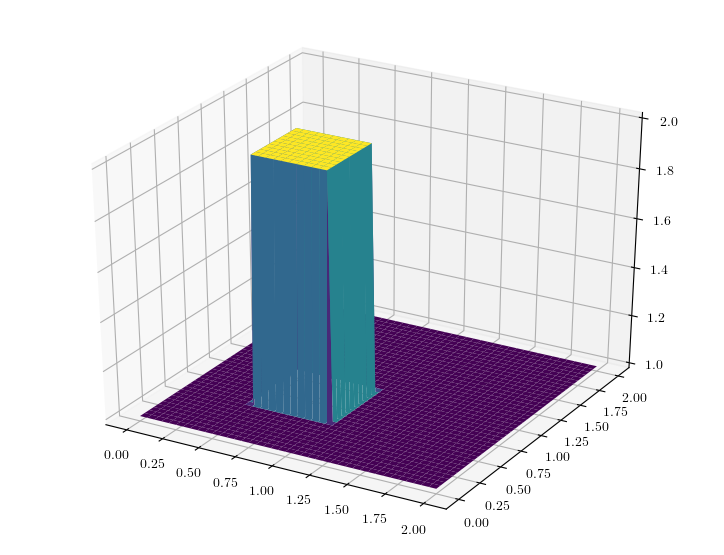

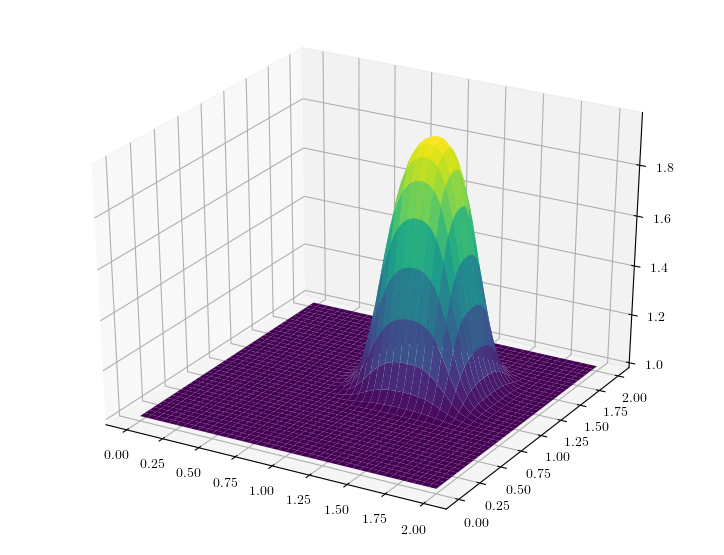

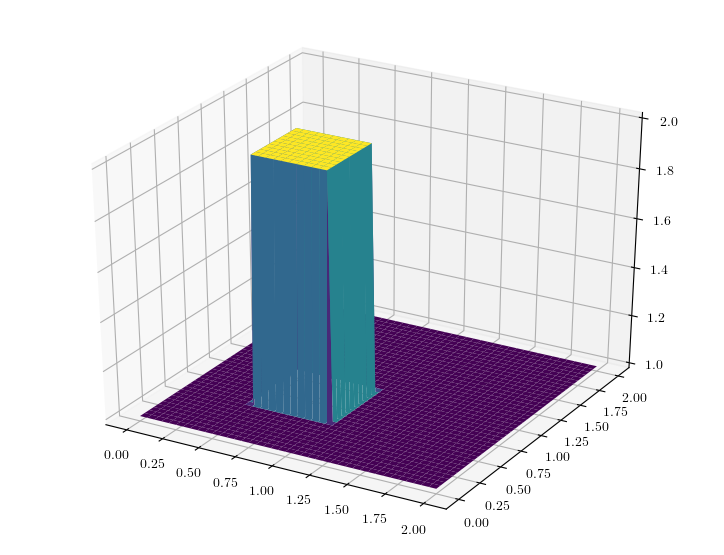

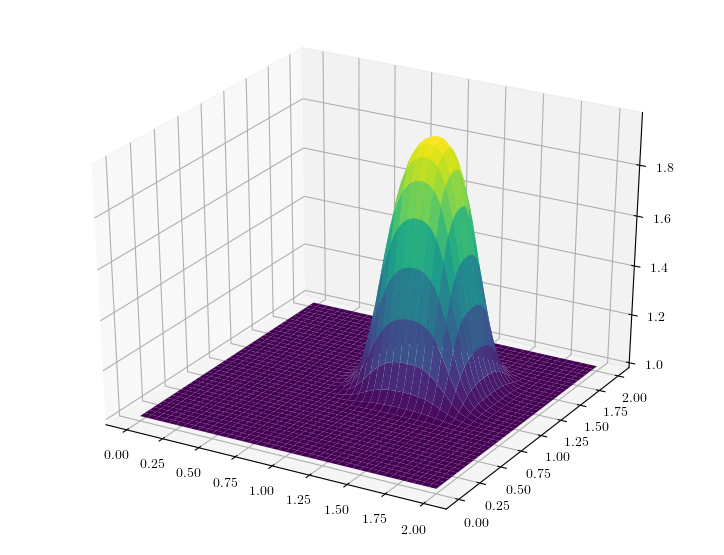

In [8]:
def linearconv2D(fast=True):
    nx = 81
    ny = 81
    dx = 2.0/(nx - 1)
    dy = 2.0/(ny - 1)
    c = 1
    sigma = 0.2
    nt = 100
    dt = sigma*dx

    x = numpy.linspace(0, 2, nx)
    y = numpy.linspace(0, 2, ny)
    
    u = numpy.ones((ny,nx))
    un = numpy.ones((ny,nx))
    u[int(0.5/dy):int(1.0/dy + 1),int(.5/dx):int(1.0/dx + 1)] = 2 
    
    fig = pyplot.figure(figsize=(9,7),dpi=100)
    ax = fig.gca(projection='3d')
    X, Y = numpy.meshgrid(x,y)
    surf = ax.plot_surface(X, Y, u[:], cmap=cm.viridis)
    
    if fast:
        tick = timeit.default_timer()
        for n in range(nt + 1):
            un = u.copy()
            u[1:,1:] = u[1:,1:] - c*dt*((u[1:,1:] - u[:-1,1:])/dx + (u[1:,1:] - u[1:,:-1])/dy)
            u[0,:] = 1
            u[-1,:] = 1
            u[:,0] = 1
            u[:,-1] = 1
        tock = timeit.default_timer()
        print('Array operations took %s seconds' %(tock - tick))
    else:
        tick = timeit.default_timer()
        for n in range(nt + 1):
            un = u.copy()
            row, col = u.shape
            for j in range(1, row):
                for i in range(1, col):
                    u[j,i] = un[j,i] - c*dt*((un[j,i] - un[j,i-1])/dx + (un[j,i] - un[j-1,i])/dy)
                    u[0,:] = 1
                    u[-1,:] = 1
                    u[:,0] = 1
                    u[:,-1] = 1
        tock = timeit.default_timer()
        print('For loops took %s seconds' %(tock - tick))
        
    fig = pyplot.figure(figsize=(9, 7), dpi=100)
    ax = fig.gca(projection='3d')
    surf2 = ax.plot_surface(X, Y, u[:], cmap=cm.viridis)
    
linearconv2D()
linearconv2D(False)

#### Student

This function takes the mesh size in each direction as separate inputs and also the required simulation time. It minimises the time-step based on the smaller grid distance between `x` and `y` for accuracy (at the cost of speed!).

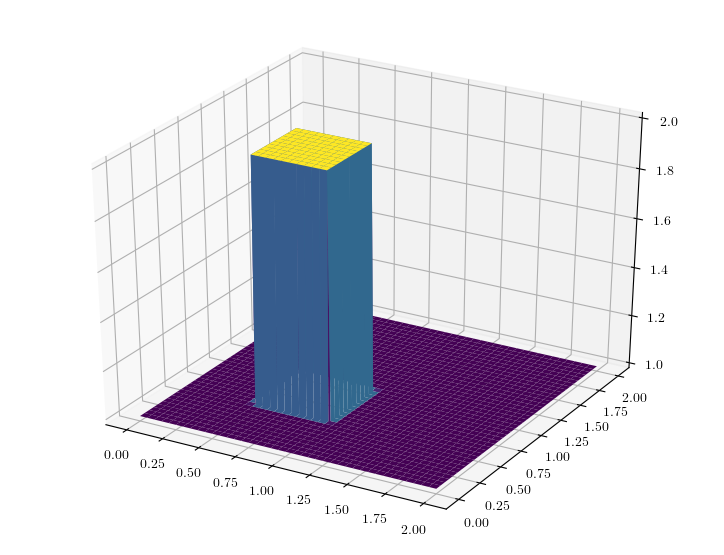

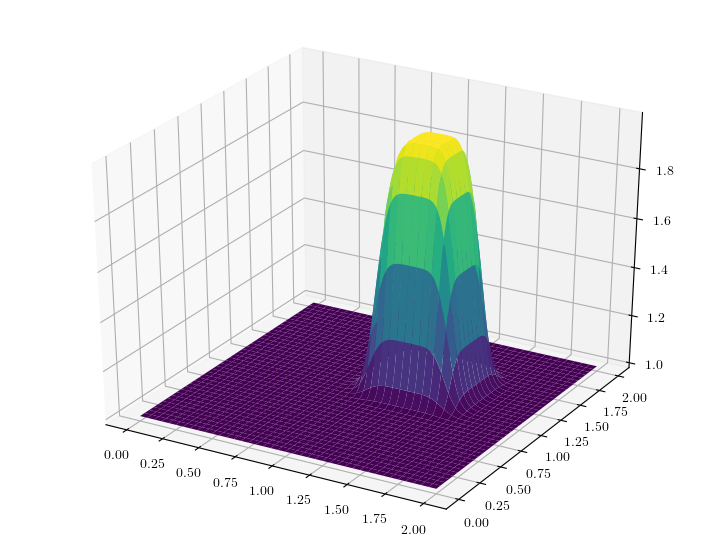

In [15]:
def linearConvection2D(mesh_size_x, mesh_size_y, time):
    dx = 2/(mesh_size_x - 1)
    dy = 2/(mesh_size_y - 1)
    c = 1
    sigma = 0.2
    dt = sigma*min(dx,dy)
    timesteps = int(time/dt)
    
    x = numpy.linspace(0,2, mesh_size_x)
    y = numpy.linspace(0,2, mesh_size_y)
    
    u = numpy.ones((timesteps, mesh_size_x, mesh_size_y))
    u[0][int(0.5/dy):int(1.0/dy + 1),int(.5/dx):int(1.0/dx + 1)] = 2
    
    for n in range(timesteps-1):
        u[n+1][1:,1:] = u[n][1:,1:] - c*dt*((u[n][1:,1:] - u[n][:-1,1:])/dx + (u[n][1:,1:] - u[n][1:,:-1])/dy)
        u[n+1][0,:] = 1
        u[n+1][-1,:] = 1
        u[n+1][:,0] = 1
        u[n+1][:,-1] = 1
        
    return x, y, u
    
pos_x, pos_y, vel = linearConvection2D(201, 201, 2.5/5.0)

# Plotting
fig = pyplot.figure(1, figsize=(9,7), dpi=100)
ax = fig.gca(projection='3d')
X, Y = numpy.meshgrid(pos_x, pos_y)
surf = ax.plot_surface(X, Y, vel[0], cmap=cm.viridis)

fig2 = pyplot.figure(2, figsize=(9,7), dpi=100)
ax = fig2.gca(projection='3d')
X, Y = numpy.meshgrid(pos_x, pos_y)
surf2 = ax.plot_surface(X, Y, vel[-1], cmap=cm.viridis)
pyplot.show()

### **Step 6: 2D Convection**

#### Professor

Coupled partial differential equations:

$$ \frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y}  = 0 $$

$$ \frac{\partial v}{\partial t} + u\frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y}  = 0 $$

(I think there's a factor $c$ missing in them.) Discretised:

$$ \frac{u^{n+1}_{i,j} - u^n_{i,j}}{\Delta t} + u^n_{i,j}\left(\frac{u^n_{i,j} - u^n_{i-1,j}}{\Delta x}\right) + v^n_{i,j}\left(\frac{u^n_{i,j} - u^n_{i,j-1}}{\Delta y}\right) = 0 $$

$$ \frac{v^{n+1}_{i,j} - v^n_{i,j}}{\Delta t} + u^n_{i,j}\left(\frac{v^n_{i,j} - v^n_{i-1,j}}{\Delta x}\right) + v^n_{i,j}\left(\frac{v^n_{i,j} - v^n_{i,j-1}}{\Delta y}\right) = 0 $$

Initial conditions:

$$ u, v = \begin{cases} 2, & x,y \in [0.5,1] \times [0.5,1] \\ 1, & \mathrm{everywhere\;else} \end{cases}$$

Boundary conditions:

$$ u = 1, v = 1 \;\mathrm{for} \begin{cases} x = 0,2 \\ y = 0,2 \end{cases} $$


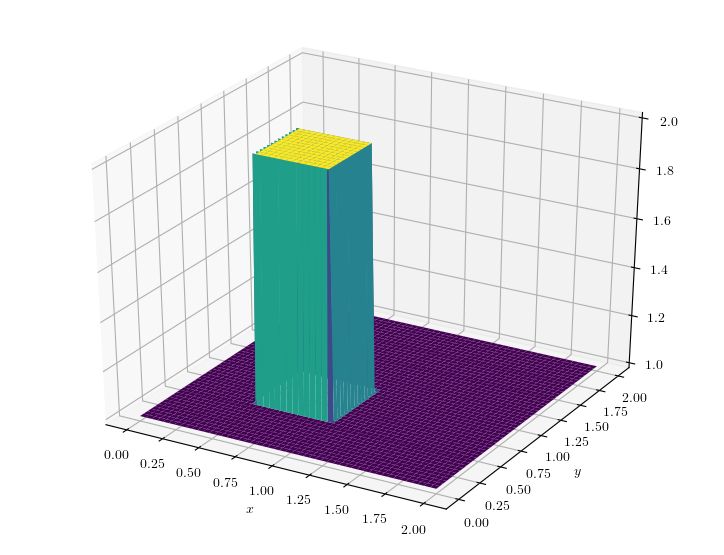

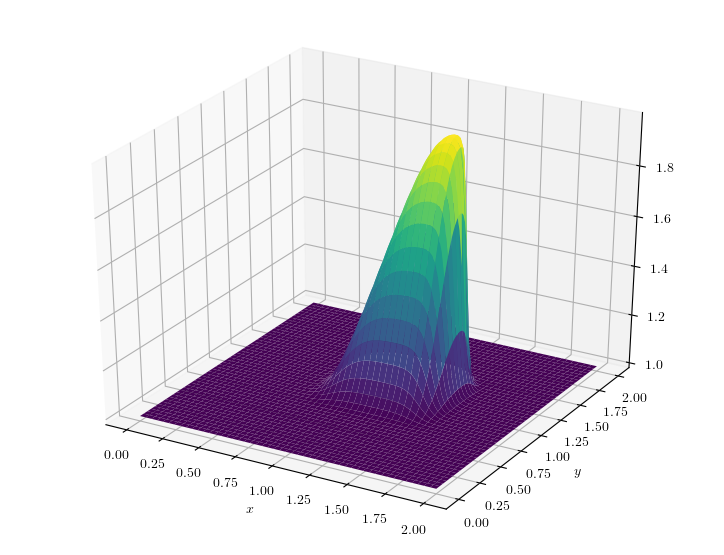

In [49]:
nx = 101
ny = 101
nt = 80
c = 1
dx = 2.0/(nx-1)
dy = 2.0/(ny-1)
sigma = 0.2
dt = sigma*dx

x = numpy.linspace(0, 2, nx)
y = numpy.linspace(0, 2, ny)

u = numpy.ones((ny, nx))
v = numpy.ones((ny, nx))
un = numpy.ones((ny, nx))
vn = numpy.ones((ny, nx))

u[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2  
v[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2  

fig = pyplot.figure(figsize=(9,7), dpi=100)
ax = fig.gca(projection='3d')
X, Y = numpy.meshgrid(x, y)

ax.plot_surface(X, Y, u, cmap=cm.viridis, rstride=2, cstride=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

for n in range(nt + 1):
    un = u.copy()
    vn = v.copy()
    u[1:, 1:] = un[1:, 1:] - un[1:, 1:] * c * dt / dx * (un[1:, 1:] - un[1:, :-1]) - vn[1:, 1:] * c * dt / dy * (un[1:, 1:] - un[:-1, 1:])
    v[1:, 1:] = vn[1:, 1:] - un[1:, 1:] * c * dt / dx * (vn[1:, 1:] - vn[1:, :-1]) - vn[1:, 1:] * c * dt / dy * (vn[1:, 1:] - vn[:-1, 1:])
    u[0, :] = 1
    u[-1, :] = 1
    u[:, 0] = 1
    u[:, -1] = 1
    
    v[0, :] = 1
    v[-1, :] = 1
    v[:, 0] = 1
    v[:, -1] = 1

fig = pyplot.figure(figsize=(9, 7), dpi=100)
ax = fig.gca(projection='3d')

ax.plot_surface(X, Y, u, cmap=cm.viridis, rstride=2, cstride=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
pyplot.show()

#### Student

These PDEs can be written concisely in tensor notation using Einstein's summation convention:

$$ \partial_t V^{\alpha} + cV^{\mu}\partial_{\mu}V^{\alpha} = 0 $$ 

However, there doesn't seem to be a neat way to write the discretisation in index notation. The computation has been made slightly more efficient by computing `c*dt/dx` and `c*dt/dy` outside the `for` loop, since those values are fixed do not need to be computed repeatedly. The same applies to the boundary conditions.

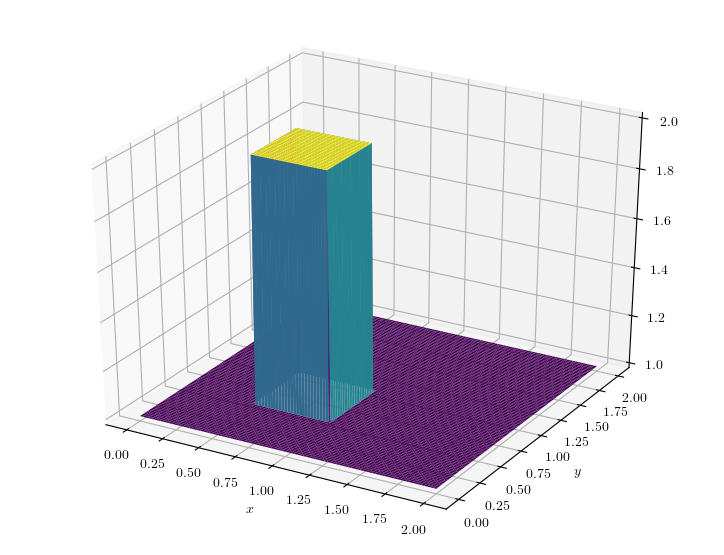

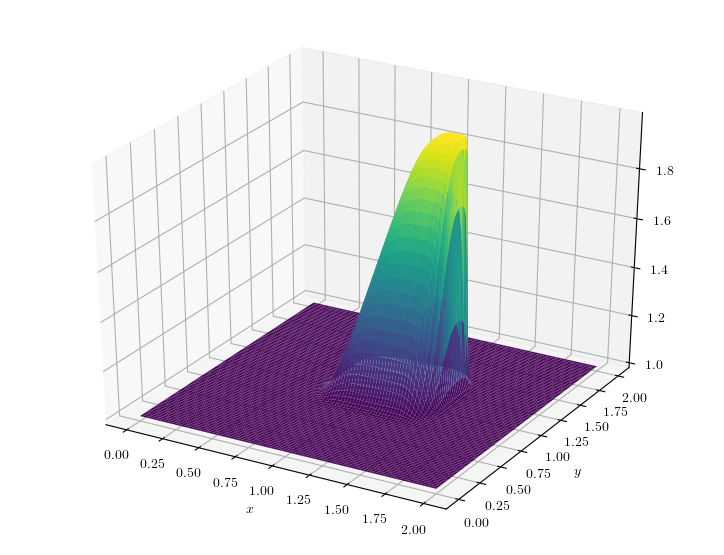

In [52]:
def convection2D(mesh_size_x, mesh_size_y, time):
    c = 1.0
    dx = 2.0/(mesh_size_x-1)
    dy = 2.0/(mesh_size_y-1)
    sigma = 0.2
    dt = sigma*min(dx,dy)
    timesteps = int(time/dt)
    
    x = numpy.linspace(0, 2.0, mesh_size_x)
    y = numpy.linspace(0, 2.0, mesh_size_y)

    u = numpy.ones((timesteps, mesh_size_x, mesh_size_y))
    v = numpy.ones((timesteps, mesh_size_x, mesh_size_y))
    
    # Initial conditions
    u[0][int(.5/dx):int(1/dx + 1),int(.5/dy):int(1/dy + 1)] = 2.0
    v[0][int(.5/dx):int(1/dx + 1),int(.5/dy):int(1/dy + 1)] = 2.0
    
    # Boundary conditions
    u[1:][0,:] = 1.0
    u[1:][-1,:] = 1.0
    u[1:][:,0] = 1.0
    u[1:][:,-1] = 1.0
    v[1:][0,:] = 1.0
    v[1:][-1,:] = 1.0
    v[1:][:,0] = 1.0
    v[1:][:,-1] = 1.0
    
    ctx = c*dt/dx
    cty = c*dt/dy
    for n in range(timesteps-1):
        u[n+1][1:,1:] = u[n][1:,1:] - ctx*(u[n][1:,1:]*(u[n][1:,1:] - u[n][:-1,1:])) - cty*(v[n][1:,1:]*(u[n][1:,1:] - u[n][1:,:-1]))
        v[n+1][1:,1:] = v[n][1:,1:] - ctx*(u[n][1:,1:]*(v[n][1:,1:] - v[n][:-1,1:])) - cty*(v[n][1:,1:]*(v[n][1:,1:] - v[n][1:,:-1]))

    return x, y, u, v
    
pos_x, pos_y, vel_x, vel_y = convection2D(201, 201, 0.32)

# Plotting
fig = pyplot.figure(1, figsize=(9, 7), dpi=100)
ax = fig.gca(projection='3d')
X, Y = numpy.meshgrid(pos_x, pos_y)
surf = ax.plot_surface(X, Y, vel_x[0], cmap=cm.viridis, rstride=2, cstride=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

fig2 = pyplot.figure(2, figsize=(9, 7), dpi=100)
ax = fig2.gca(projection='3d')
X, Y = numpy.meshgrid(pos_x, pos_y)
surf2 = ax.plot_surface(X, Y, vel_y[-1], cmap=cm.viridis, rstride=2, cstride=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
pyplot.show()

### **Step 7: 2D Diffusion**

#### Professor

Partial differential equation: 

$$ \frac{\partial u}{\partial t} = \nu\left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}\right) $$

Discretised: 

$$ \frac{u^{n+1}_i - u^n_i}{\Delta t} = \nu\left[\frac{u^n_{i+1} - 2u^n_i + u^n_{i-1}}{(\Delta x)^2} + \frac{u^n_{i+1} - 2u^n_i + u^n_{i-1}}{(\Delta y)^2}\right] $$

Initial conditions:

$$ u, v = \begin{cases} 2, & x,y \in [0.5,1] \times [0.5,1] \\ 1, & \mathrm{everywhere\;else} \end{cases}$$

Boundary conditions:

$$ u = 1, v = 1 \;\mathrm{for} \begin{cases} x = 0,2 \\ y = 0,2 \end{cases} $$

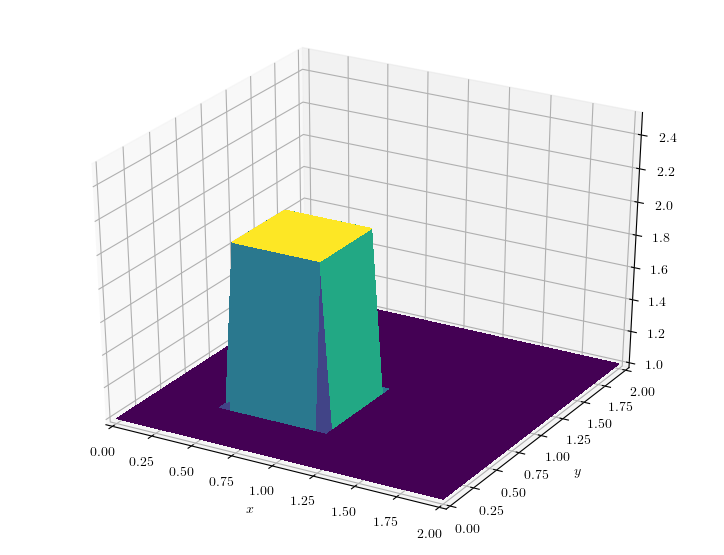

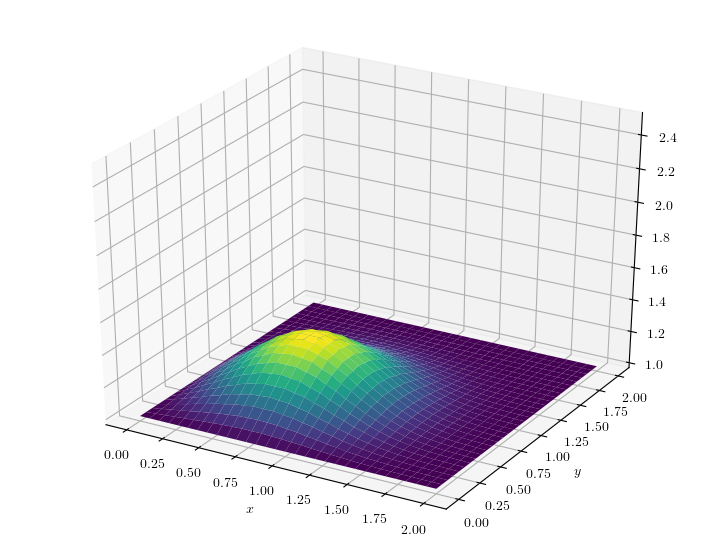

In [27]:
nx = 31
ny = 31
nu = .05
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
sigma = .25
dt = sigma*dx*dy/nu

x = numpy.linspace(0,2,nx)
y = numpy.linspace(0,2,ny)

u = numpy.ones((ny,nx))
un = numpy.ones((ny,nx))

u[int(.5/dy):int(1/dy+1),int(.5/dx):int(1/dx+1)] = 2

fig = pyplot.figure(figsize=(9,7), dpi = 100)
ax = fig.gca(projection='3d')
X, Y = numpy.meshgrid(x, y)
surf = ax.plot_surface(X, Y, u, rstride=1, cstride=1, cmap=cm.viridis,
        linewidth=0, antialiased=False)

ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
ax.set_zlim(1, 2.5)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

def diffuse(nt):
    u[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2  # Why is this repeated?

    for n in range(nt+1):
        un = u.copy()
        u[1:-1, 1:-1] = (un[1:-1,1:-1] + nu * dt / dx**2 * (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) + nu * dt / dy**2 * (un[2:,1: -1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1]))
        u[0,:] = 1
        u[-1,:] = 1
        u[:,0] = 1
        u[:,-1] = 1
    
    fig2 = pyplot.figure(figsize=(9,7), dpi = 100)
    ax = fig2.gca(projection='3d')
    surf2 = ax.plot_surface(X, Y, u[:], rstride=1, cstride=1, cmap=cm.viridis,
        linewidth=0, antialiased=True)
    ax.set_zlim(1, 2.5)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    
diffuse(50)

#### Student

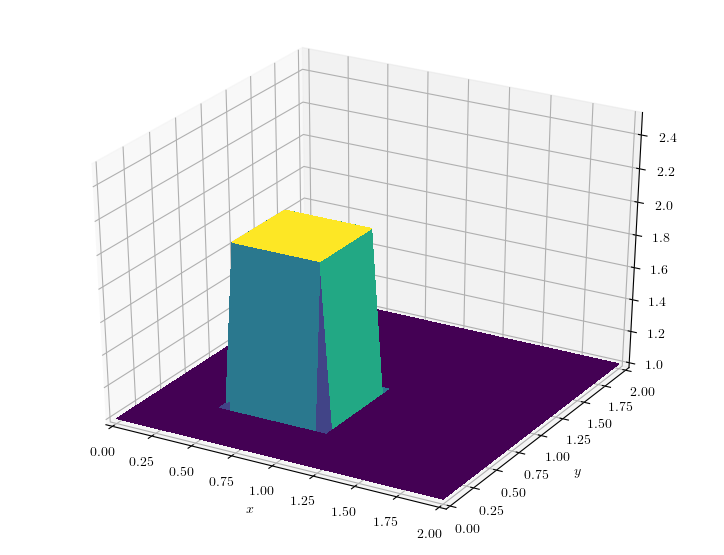

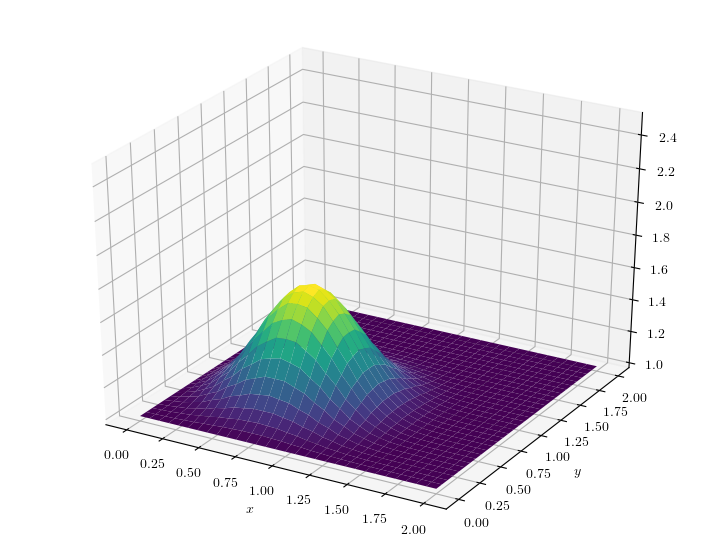

In [36]:
def diffusion2D(mesh_size_x, mesh_size_y, time):
    nu = 0.05
    dx = 2.0/(mesh_size_x-1)
    dy = 2.0/(mesh_size_y-1)
    sigma = 0.25
    dt = sigma*dx*dy/nu
    timesteps = int(time/dt)
    
    x = numpy.linspace(0, 2, mesh_size_x)
    y = numpy.linspace(0, 2, mesh_size_y)

    u = numpy.ones((timesteps, mesh_size_x, mesh_size_y))
    
    # Initial conditions
    u[0][int(.5/dx):int(1/dx + 1),int(.5/dy):int(1/dy + 1)] = 2
    
    # Boundary conditions
    u[1:][0,:] = 1
    u[1:][-1,:] = 1
    u[1:][:,0] = 1
    u[1:][:,-1] = 1
    
    lambda_x = nu*dt/dx**2
    lambda_y = nu*dt/dy**2
    for n in range(timesteps-1):
        u[n+1][1:-1,1:-1] = u[n][1:-1,1:-1] + lambda_x*(u[n][1:-1,2:] - 2*u[n][1:-1,1:-1] + u[n][1:-1,0:-2]) + lambda_y*(u[n][2:,1:-1,] - 2*u[n][1:-1,1:-1] + u[n][0:-2,1:-1])
        
    return x, y, u
    
pos_x, pos_y, vel_x = diffusion2D(31, 31, 0.5)

# Plotting
fig = pyplot.figure(1, figsize=(9, 7), dpi=100)
ax = fig.gca(projection='3d')
X, Y = numpy.meshgrid(pos_x, pos_y)
surf = ax.plot_surface(X, Y, vel_x[0], rstride=1, cstride=1, cmap=cm.viridis, linewidth=0, antialiased=False)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_xlim(0,2)
ax.set_ylim(0,2)
ax.set_zlim(1,2.5)


fig2 = pyplot.figure(2, figsize=(9, 7), dpi=100)
ax = fig2.gca(projection='3d')
X, Y = numpy.meshgrid(pos_x, pos_y)
surf2 = ax.plot_surface(X, Y, vel_x[-1], rstride=1, cstride=1, cmap=cm.viridis, linewidth=0, antialiased=True)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlim(1,2.5)

pyplot.show()

### **Step 8: Burgers' Equation in 2D**

#### Professor

Partial differential equations: 

$$ \frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y} = \nu\left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}\right) $$

$$ \frac{\partial v}{\partial t} + u\frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y} = \nu\left(\frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2}\right) $$

Discretised: 

$$ \frac{u^{n+1}_i - u^n_i}{\Delta t} + u^n_{i,j}\left(\frac{u^n_{i,j} - u^n_{i-1,j}}{\Delta x}\right) + v^n_{i,j}\left(\frac{u^n_{i,j} - u^n_{i,j-1}}{\Delta y}\right) = \nu\left[\frac{u^n_{i+1} - 2u^n_i + u^n_{i-1}}{(\Delta x)^2} + \frac{u^n_{i+1} - 2u^n_i + u^n_{i-1}}{(\Delta y)^2}\right] $$

$$ \frac{v^{n+1}_i - v^n_i}{\Delta t} + u^n_{i,j}\left(\frac{v^n_{i,j} - v^n_{i-1,j}}{\Delta x}\right) + v^n_{i,j}\left(\frac{v^n_{i,j} - v^n_{i,j-1}}{\Delta y}\right) = \nu\left[\frac{v^n_{i+1} - 2v^n_i + v^n_{i-1}}{(\Delta x)^2} + \frac{v^n_{i+1} - 2v^n_i + v^n_{i-1}}{(\Delta y)^2}\right] $$

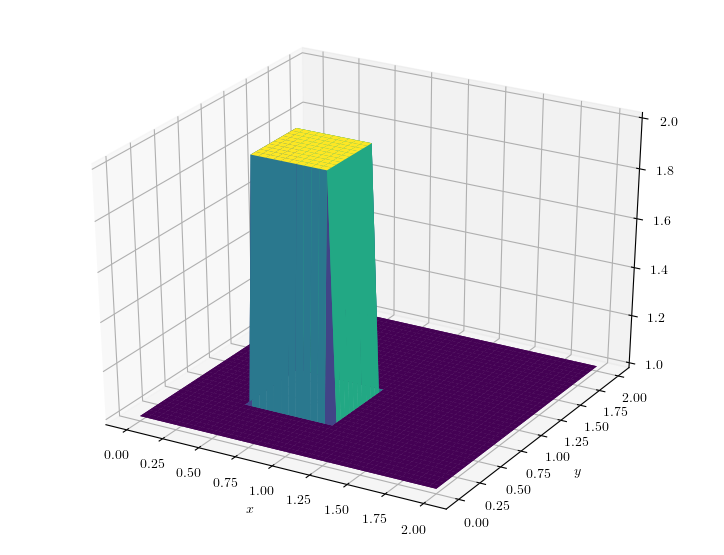

In [42]:
nx = 41
ny = 41
nt = 120
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
sigma = .0009
nu = 0.01
dt = sigma * dx * dy / nu

x = numpy.linspace(0, 2, nx)
y = numpy.linspace(0, 2, ny)

u = numpy.ones((ny, nx))
v = numpy.ones((ny, nx))
un = numpy.ones((ny, nx)) 
vn = numpy.ones((ny, nx))
comb = numpy.ones((ny, nx))

u[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2 
v[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2 

fig = pyplot.figure(figsize=(9, 7), dpi=100)
ax = fig.gca(projection='3d')
X, Y = numpy.meshgrid(x, y)
ax.plot_surface(X, Y, u[:], cmap=cm.viridis, rstride=1, cstride=1)
ax.plot_surface(X, Y, v[:], cmap=cm.viridis, rstride=1, cstride=1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
pyplot.show()